http://cv-tricks.com/tensorflow-tutorial/understanding-alexnet-resnet-squeezenetand-running-on-tensorflow/

In [1]:
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
downscale = 8
naosei = cv.imread('./data/esperanca.png', 0)
dimensions = (int(naosei.shape[1]/downscale), int(naosei.shape[0]/downscale))
naosei = cv.resize(naosei, dimensions)

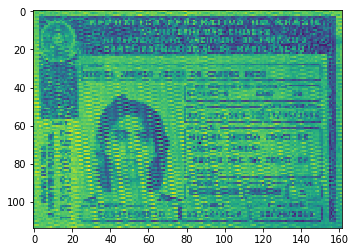

In [3]:
%matplotlib inline
plt.imshow(naosei)

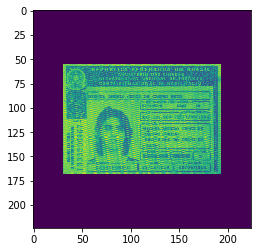

In [4]:
pad_to_224_x = int((224 - naosei.shape[0])/2)
pad_to_224_y = int((224 - naosei.shape[1])/2)
naosei = np.pad(naosei, ((pad_to_224_x, pad_to_224_x), (pad_to_224_y, pad_to_224_y)), 'constant', constant_values=(0, 0))
plt.imshow(naosei)

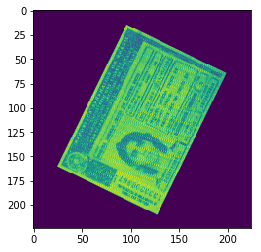

In [5]:
def img_rotate(img, angle):
    num_rows, num_cols = img.shape[:2]
    rotation_matrix = cv.getRotationMatrix2D((num_cols/2, num_rows/2), angle, 1)
    img_rotation = cv.warpAffine(img, rotation_matrix, (num_cols, num_rows))
    return img_rotation

modacaralha = img_rotate(naosei, int(random.random()*360))
plt.imshow(modacaralha)

In [6]:
def create_batch(img, size):
    batch_x, batch_y = [], []
    for i in range(size):
        rotation_val = random.random()
        rotated_img = img_rotate(naosei, int(rotation_val*360))
        batch_x.append(rotated_img.ravel())
        batch_y.append([rotation_val])
    return batch_x, batch_y

In [7]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.nn.relu(tf.matmul(input_layer, W) + b)

In [8]:
from tensorflow.contrib import slim

In [9]:
COLOR_CHANNELS = 1
data_ph = tf.placeholder(tf.float32, shape=[None, COLOR_CHANNELS*224**2])
output_ph = tf.placeholder(tf.float32, shape=[None, 1])
learning_rate = tf.placeholder('float', [])

In [10]:
def conv_pool(x_image, scope=None, reuse=None):
    hl = tf.layers.batch_normalization(slim.conv2d(x_image, 10, [5, 5]))
    hl = slim.max_pool2d(hl, 2)
    print(hl.shape)
    return hl

In [11]:
x_image = tf.reshape(data_ph, [-1, 224, 224, COLOR_CHANNELS])
hl = slim.repeat(x_image, 5, conv_pool)
hl = slim.flatten(hl)
print(hl.shape)

(?, 112, 112, 10)
(?, 56, 56, 10)
(?, 28, 28, 10)
(?, 14, 14, 10)
(?, 7, 7, 10)
(?, 490)


In [12]:
fc = slim.stack(hl, slim.fully_connected, [490, 46, 10, 1])
print(fc.shape)

(?, 1)


In [13]:
loss = tf.reduce_mean((fc - output_ph)**2)
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [14]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
%matplotlib notebook
import time

batch_size = 3
steps = 200000
rate = 3e-6

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = create_batch(naosei, batch_size)
        feed = {data_ph:batch_x, output_ph:batch_y, learning_rate:rate}
        sess.run(train, feed_dict=feed)
        
        if i%100 == 0:
            last_loss = sess.run(loss, feed_dict = feed)
            print(last_loss)
            pred = sess.run(fc, feed_dict={data_ph:[modacaralha.ravel()]})
            print(pred)
            ax.clear()
            ax.imshow(img_rotate(modacaralha, -360*pred))
            fig.canvas.draw()
    test_batch, _ = create_batch(naosei, 10)
    final_pred = sess.run(fc, feed_dict={data_ph:test_batch})

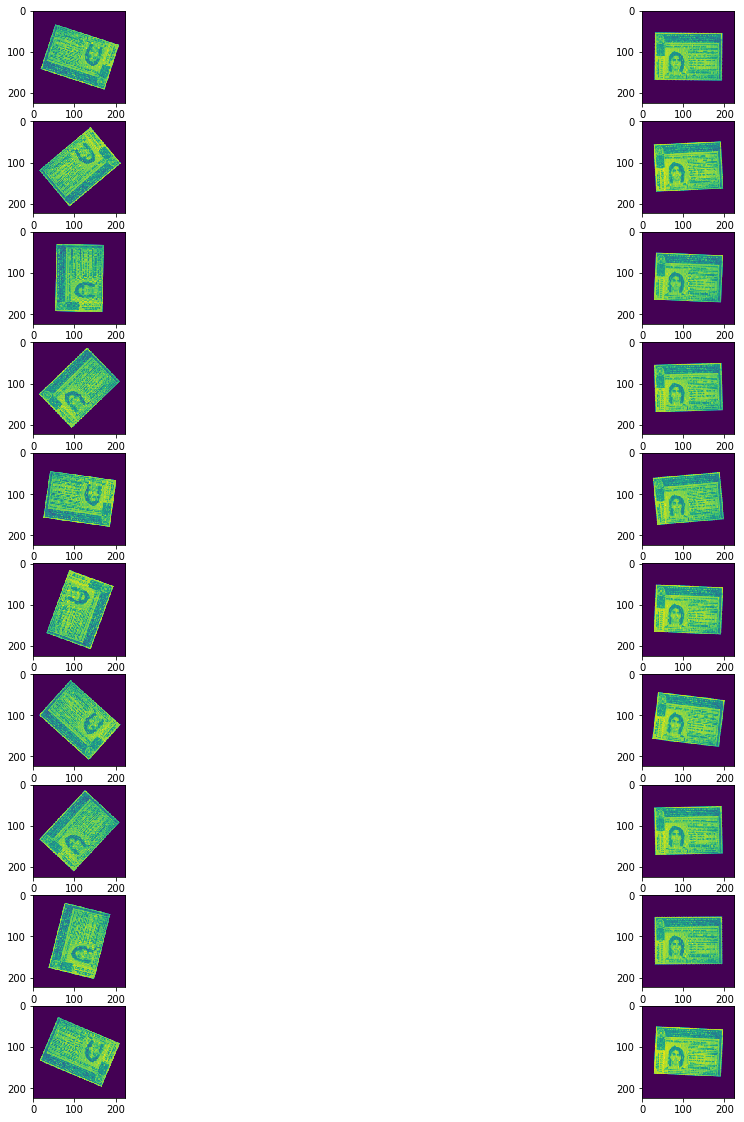

In [22]:
%matplotlib inline
plots = []
fig = plt.figure(figsize=(20,20))
__=0
for i in range(len(final_pred)):
    plots.append(fig.add_subplot(10, 2, __+1))
    plots[__].imshow(test_batch[i].reshape(224,224))
    plots.append(fig.add_subplot(10, 2, __+2))
    plots[__+1].imshow(img_rotate(test_batch[i].reshape(224, 224), -360*final_pred[i]))
    __ += 2
    